In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import Sequential, Model
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [2]:
from keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [4]:
from keras.utils import np_utils

num_classes = 10 
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [5]:
# input image dimensions 28x28 pixel images. 
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


In [6]:
from resnet import ResNet50

In [12]:
resnet = ResNet50(input_shape = (28,28,1), classes = 10)

In [13]:
resnet.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 11, 11, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 11, 11, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 11, 11, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [14]:
import os
import datetime
import numpy as np
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 2                                                         
batch_size = 256                                                     

callback = {"early_stopping": EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=False),
            "tensorboard"   : tf.keras.callbacks.TensorBoard(log_dir=log_dir), # %load_ext tensorboard, %tensorboard --logdir logs
            "reduce_lr"     : ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), patience=5, min_lr=0.5e-6),
            "check_point"   : ModelCheckpoint("model", save_best_only=True, verbose=1),
            "log_csv"       : CSVLogger("training.csv") 
           }

resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     optimizer="Adam",
                     metrics=['accuracy'], )                                           
 
history = resnet.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test),
          epochs=epochs, callbacks=[callback["check_point"]])   

Epoch 1/2
 80/235 [=========>....................] - ETA: 14:32 - loss: 1.9752 - accuracy: 0.4819

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
def plot_metrics(metric_name, title):
    plt.title(title)
    #plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.show()

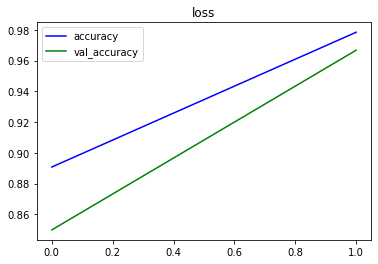

In [11]:
plot_metrics("accuracy", "loss")